<a href="https://colab.research.google.com/github/afaqahmed91/machinelearning/blob/main/tanzania_water_pump/TanzaniaWaterPump_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 9.1 MB/s eta 0:00:00


In [4]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [5]:
def distance(df: pd.DataFrame, lat: float, lon: float) -> float:
    p = 0.017453292519943295
    lat_diff = (df["latitude"] - lat) * p
    lon_diff = (df["longitude"] - lon) * p
    hav = (
        0.5
        - np.cos(lat_diff) / 2
        + np.cos(lat * p) * np.cos(df["latitude"] * p) * (1 - np.cos(lon_diff)) / 2
    )
    return 12742 * np.arcsin(np.sqrt(hav))


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the input DataFrame by imputing missing values, creating new features,
    and dropping unnecessary columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing raw data.

    Returns:
    pd.DataFrame: The preprocessed DataFrame with imputed values, new features,
                  and selected columns.

    Imputations and Transformations:
    - longitude: Impute missing values (0) based on the mean longitude of the region code.
    - gps_height: Impute missing values (0) based on the mean gps_height of the basin.
    - center_distance: Calculate the distance from a central point (-6.5, 37.5).
    - population: Impute missing values (0 or 1) based on the mean population of the basin.
    - age: Calculate the age of the water point based on the recorded date and construction year.
    - quantity: Replace 'unknown' with 'dry' and convert to categorical type.
    - public_meeting: Fill missing values with False and convert to integer type.
    - permit: Fill missing values with False and convert to integer type.
    - funder: Fill missing values with 'Unknown', keep top 10 funders, and convert to categorical type.
    - installer: Fill missing values with 'Unknown', replace '0' with 'Unknown', keep top 10 installers, and convert to categorical type.
    - ground_water: Replace 'groundwater' with 1, 'surface' with 0, 'unknown' with 1, and convert to integer type.
    - age: Recalculate age, replacing negative or NaN values with the mean age.

    Dropped Columns:
    - region_code, date_recorded, construction_year, water_quality, extraction_type,
      payment, scheme_management, waterpoint_type_group, scheme_name, amount_tsh,
      subvillage, num_private, district_code, recorded_by, wpt_name, ward,
      quantity_group, source_class, source_type, latitude, longitude.
    """
    return (
        df.assign(
            # imputed longitude based on region code
            longitude=np.where(
                df["longitude"] == 0,
                df["region_code"].map(
                    df.groupby("region_code")["longitude"].mean().to_dict()
                ),
                df["longitude"],
            ),
            # imputed longitude based on basin
            gps_height=np.where(
                df["gps_height"] == 0,
                df["basin"].map(df.groupby("basin")["gps_height"].mean().to_dict()),
                df["gps_height"],
            ),
            center_distance=lambda x: distance(x, -6.5, 37.5),
            population=np.where(
                (df["population"] == 0) | (df["population"] == 1),
                df["basin"].map(
                    df.groupby("basin")["population"].mean().astype(int).to_dict()
                ),
                df["population"],
            ),
            age=(
                df["date_recorded"].str.split("-").str[0].astype(int)
                - df["construction_year"].replace(0, np.nan)
            ),
            quantity=df.quantity.replace({"unknown": "dry"})
            # .replace({"dry": 1, "insufficient": 2, "seasonal": 3, "enough": 4})
            .astype("category"),
            public_meeting=df.public_meeting.fillna(False).astype(int),
            permit=df.permit.fillna(False).astype(int),
            funder=df.funder.fillna("Unknown").pipe(topn, n=10).astype("category"),
            installer=df.installer.fillna("Unknown")
            .replace({"0": "Unknown"})
            .pipe(topn, n=10)
            .astype("category"),
            ground_water=df.source_class.replace(
                {"groundwater": 1, "surface": 0, "unknown": 1}
            ).astype(int),
        )
        .assign(
            age=lambda _df: np.where(
                (_df["age"] < 0) | (_df["age"].isna()), _df["age"].mean(), _df["age"]
            )
        )
        .drop(
            columns=[
                "region_code",
                "date_recorded",
                "construction_year",
                "latitude",
                "longitude",
                "water_quality",
                "extraction_type",
                "payment",
                "scheme_management",
                "waterpoint_type_group",
                "scheme_name",
                "amount_tsh",
                "subvillage",
                "num_private",
                "district_code",
                "recorded_by",
                "wpt_name",
                "ward",
                "quantity_group",
                "source_class",
                "source_type",
            ]
        )
    )


def topn(ser: pd.Series, n: int = 5, default: str = "other"):
    """
    Replace values in a pandas Series with 'default' if they are not among the top 'n' most frequent values.

    Parameters:
    ser (pandas.Series): The input pandas Series.
    n (int, optional): The number of top most frequent values to keep. Defaults to 5.
    default (str, optional): The value to replace non-top 'n' values with. Defaults to "other".

    Returns:
    pandas.Series: A pandas Series with non-top 'n' values replaced by 'default'.
    """
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)


def preprocess_y(df):
    return (
        df["status_group"]
        .replace({"functional": 2, "non functional": 0, "functional needs repair": 1})
        .values
    )

In [6]:
raw_x = pd.read_csv(
    "https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/training_set_values.csv",
    index_col="id",
)
raw_y = pd.read_csv(
    "https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/training_set_labels.csv",
    index_col="id",
)

In [7]:
processed_x = preprocess_data(raw_x)
processed_y = preprocess_y(raw_y)

/tmp/ipykernel_14687/2641034840.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  public_meeting=df.public_meeting.fillna(False).astype(int),
/tmp/ipykernel_14687/2641034840.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  permit=df.permit.fillna(False).astype(int),
/tmp/ipykernel_14687/2641034840.py:83: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no

In [8]:
pump_X_train, pump_X_test, y_train, y_test = train_test_split(
    processed_x, processed_y, random_state=40, train_size=0.75, stratify=processed_y
)

In [9]:
cate_vars = [
    "funder",
    "installer",
    "basin",
    "region",
    "lga",
    "extraction_type_group",
    "extraction_type_class",
    "management",
    "management_group",
    "payment_type",
    "quality_group",
    "quantity",
    "source",
    "waterpoint_type",
]

encoder = encoding.OneHotEncoder(top_categories=10, drop_last=True, variables=cate_vars)

In [10]:
encoder.fit(pump_X_train)
X_train = encoder.transform(pump_X_train)
X_test = encoder.transform(pump_X_test)

In [ ]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
rf.score(X_test, y_test)

0.7894949494949495

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
n_estimators = [50, 150, 200]
max_depth = [None, 10, 30, 50]
min_samples_split = [5, 10]
min_samples_leaf = [2, 4]
class_weight = ["balanced", None]
max_features = ["auto", "sqrt"]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "class_weight": class_weight,
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = ensemble.RandomForestClassifier()
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 10, 30, 50],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [50, 150, 200]},
                   random_state=42, verbose=2)

In [ ]:
# Print the results and based on these result select proper range for the grid search
random_search.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 30,
 'class_weight': None}

In [ ]:
model = ensemble.RandomForestClassifier(
    random_state=42,
    n_estimators=150,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=30,
    class_weight=None,
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=150, random_state=42)

In [ ]:
model.score(X_test, y_test)

0.8011447811447812

# Run Best Model

In [1]:
from sklearn.metrics import accuracy_score
from yellowbrick import classifier
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:
pred = model.predict(X_test)
score = accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


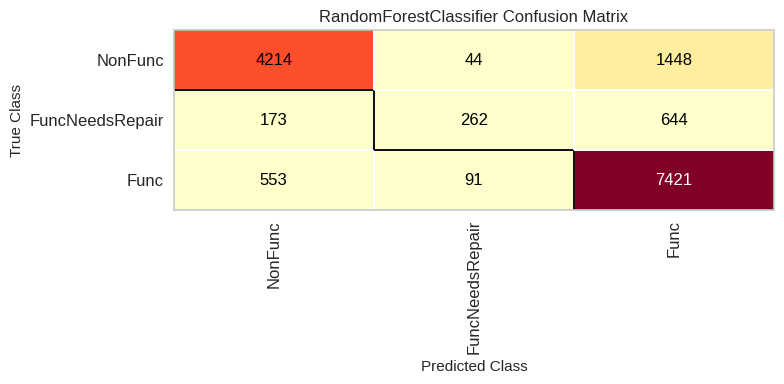

ConfusionMatrix(ax=<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['NonFunc', 'FuncNeedsRepair', 'Func'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7faf12933d90>,
                estimator=RandomForestClassifier(max_depth=30,
                                                 min_samples_leaf=2,
                                                 min_samples_split=5,
                                                 n_estimators=150,
                                                 random_state=42))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=["NonFunc", "FuncNeedsRepair", "Func"],
    ax=ax,
)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


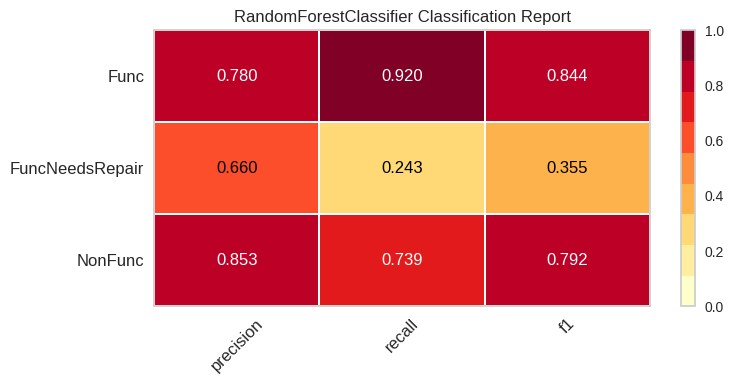

ClassificationReport(ax=<Axes: title={'center': 'RandomForestClassifier Classification Report'}>,
                     classes=['NonFunc', 'FuncNeedsRepair', 'Func'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x7faf12933dc0>,
                     estimator=RandomForestClassifier(max_depth=30,
                                                      min_samples_leaf=2,
                                                      min_samples_split=5,
                                                      n_estimators=150,
                                                      random_state=42))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    classes=["NonFunc", "FuncNeedsRepair", "Func"],
    micro=False,
    macro=False,
    ax=ax,
)

# Analysis
For detecting non functional it is necessary that the model has high recall

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

In [ ]:
y_pred_proba = model.predict_proba(X_test)

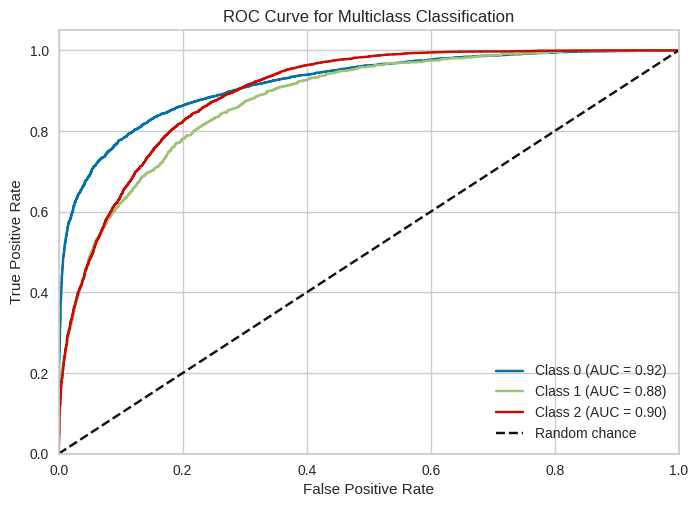

In [ ]:
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and AUC
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], "k--", label="Random chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend(loc="lower right")
plt.show()

# Testing on submission data

In [ ]:
raw_test = pd.read_csv(
    "https://raw.githubusercontent.com/afaqahmed91/machinelearning/refs/heads/main/tanzania_water_pump/data/test_set_values.csv",
    index_col="id",
)

In [ ]:
processed_test = preprocess_data(raw_test)

<ipython-input-7-6a6cd8b8a2b8>:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantity=df.quantity.replace({"unknown": "dry"}).replace(
<ipython-input-7-6a6cd8b8a2b8>:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  public_meeting=df.public_meeting.fillna(False).astype(int),
<ipython-input-7-6a6cd8b8a2b8>:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.

In [ ]:
test_data = encoder.transform(processed_test)

In [ ]:
label_predictions = model.predict(test_data)

In [ ]:
raw_test["status_group"] = (
    pd.Series(label_predictions)
    .map({2: "functional", 0: "non functional", 1: "functional needs repair"})
    .values
)

In [ ]:
raw_test["status_group"].to_csv("submission.csv")

In [ ]:
pd.Series(label_predictions).map(
    {2: "functional", 0: "non functional", 1: "functional needs repair"}
).values

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)